# Inference

In [1]:
%matplotlib inline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import pandas as pd
from PIL import Image
import mmcv
import requests
import time
import torch
from torch import nn
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from sklearn import metrics
import io
from PIL import Image
import PIL
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

We want to be able to run the model on CPU server.

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(device)

cpu


Need to define models classes...

In [3]:
class FaceRegressionModel(nn.Module):
    def __init__(self, backbone, num_points=5, hidden_size=2**11):
        '''
        backbone - CNN for reature extraction
        num_points - number of predicted points (each point has two coordinates)
        hidden_size - number of neurons in hidden FC layer before output layer
        '''
        super(FaceRegressionModel, self).__init__()
        self.num_points = num_points
        self.backbone = backbone

        self.head = nn.Sequential(
            nn.Flatten(), # now the head can work with any conv result
            nn.LazyLinear(hidden_size),
            nn.LeakyReLU(0.05),
            nn.LazyLinear(num_points * 2)
        )

    def forward(self, tensor):
        tensor = self.backbone(tensor)
        tensor = self.head(tensor)
        tensor = tensor.view(tensor.shape[0], self.num_points, -1)
        return tensor

In [4]:
class FaceRecognitionModel(nn.Module):
    def __init__(self, backbone, embed_size=512, drop_rate=0.33):
        '''
        backbone - CNN for reature extraction
        num_classes - number of predicted classes (persons)
        embed_size - embeddind dimentions
        '''
        super(FaceRecognitionModel, self).__init__()
        self.embed_size = embed_size
        self.backbone = backbone
        
        self.embed = nn.Sequential(
            nn.Flatten(), # now the head can work with any conv result
            nn.Dropout(drop_rate), # regularization
            nn.LazyLinear(embed_size, bias=False), # embed!
            nn.LazyBatchNorm1d(), # to center embeddings around 0
        )

    def forward(self, tensor):
        tensor = self.backbone(tensor)
        tensor = self.embed(tensor)
        return tensor # embeddings

# Single super class

And this is where the magic happens - class that finds similar faces.

In [5]:
class FaceFinder:
    def __init__(self, 
                 detector_weights_path,
                 regressor_model_path,
                 regressor_config_path,
                 recognitor_model_path,
                 recognitor_config_path,
                 landmark_path,
                 custom_params_recognition_path,
                 embed_path,
                 limit_rotated_face=1.5,
                 max_faces_per_image=-1,
                 device='cpu'
                ):
        
        # load trained YOLO detector
        if device == 'cpu':
            kwarg = dict(device=device)
        else:
            kwarg = {}
        self.detector = torch.hub.load('ultralytics/yolov5',
                                       'custom', 
                                       path=detector_weights_path, 
                                       force_reload=True, 
                                       **kwarg
                                      )
        
        # load trained landmark coordinate regressor
        self.regressor = torch.load(regressor_model_path, 
                                    map_location=torch.device(device))
        self.regressor.eval()
        
        # load regressor config
        with open(regressor_config_path) as infile:
            regresson_cfg = json.load(infile)
        regresson_stats = regresson_cfg['mean'], regresson_cfg['std']
        regresson_img_size = regresson_cfg['input_size'][1]
        self.regressor_basic_transform = A.Compose([
                A.Resize(regresson_img_size, regresson_img_size),
                A.Normalize(*regresson_stats),
                ToTensorV2(),
            ])
        
        # load recognition model
        self.recognitor = torch.load(
            recognitor_model_path, 
            map_location=torch.device(device))
        self.recognitor.eval()
        
        # load recognition model config
        with open(recognitor_config_path) as infile:
            recognitor_cfg = json.load(infile)
        recognitor_stats = recognitor_cfg['mean'], recognitor_cfg['std']
        self.recognitor_img_size = recognitor_cfg['input_size']
        self.recognitor_basic_transform = A.Compose([
                A.Normalize(*recognitor_stats),
                ToTensorV2(),
            ])
        
        # load custom parameters for recognition alignment
        self.custom_params = json.load(open(custom_params_recognition_path, 'r'))
        
        # list of known images + embeddings
        self.df_full = pd.read_pickle(landmark_path)
        self.embeddings = np.load(embed_path)
        
        # alignment parameters
        self.desiredEyesY = self.custom_params['desiredEyesY']
        self.desiredFaceWidth = self.custom_params['im_width']
        self.desiredFaceHeight = self.custom_params['im_height']
        
        self.vertical_face_scale = self.custom_params['vertical_face_scale']
        self.limit_rotated_face = limit_rotated_face
        
        # limit number of faces per image
        self.max_faces_per_image = max_faces_per_image
        
        self.device = device
        
    def landmarks_dist(self, coordinates):
    
        def pair_dist(xy1, xy2):
            return ((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)**0.5

        return dict(
            eye1eye2 = pair_dist(coordinates[0,:], coordinates[1,:]),
            eye1nose = pair_dist(coordinates[0,:], coordinates[2,:]),
            eye2nose = pair_dist(coordinates[1,:], coordinates[2,:]),
        )
    
    def align(self, image, coordinates, nose_weight=4):
        
        """
        Aligns image so that eyes are on a single horizontal line
        and scalse image by eye-to-eye distance OR by eyes_center-to-weighted_mouth+nose_center
        """

        leftEyeCenter = coordinates[0]
        rightEyeCenter = coordinates[1]
        
        # we will scale face by two sizes: 
        # eye-to-eye
        # eyes_center-to-weighted_lower_face_center
        mouth_weight = 1
        sum_weingt = 2 + nose_weight

        bottom_center = coordinates[2] * nose_weight + (coordinates[3] + coordinates[4])
        bottom_center = bottom_center / sum_weingt

        top_center = (leftEyeCenter + rightEyeCenter) / 2

        # compute the angle between the eye centroids
        d_eyes = rightEyeCenter - leftEyeCenter
        angle = np.degrees(np.arctan2(*d_eyes[::-1]))

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        # desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        top_bottom_dist = (np.abs(
            np.linalg.norm(
                np.cross(
                    rightEyeCenter-leftEyeCenter, 
                    leftEyeCenter-bottom_center
                )
            )
        ) / np.linalg.norm(
            rightEyeCenter-leftEyeCenter
        ))

        eyes_dist = np.linalg.norm(d_eyes)

        size_y = self.desiredFaceHeight
        scale1 = size_y / (top_bottom_dist * self.vertical_face_scale)
        scale2 = size_y / (eyes_dist * self.vertical_face_scale / 1.29)

        # scale image to get same distance between eyes OR between top and bottom "face centers"
        scale = min(scale1, scale2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(top_center, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredEyesY
        M[0, 2] += (tX - top_center[0])
        M[1, 2] += (tY - top_center[1])

        # apply the affine transformation
        output = cv2.warpAffine(src=image, 
                                M=M, 
                                dsize=(
                                    self.desiredFaceWidth, 
                                    self.desiredFaceHeight
                                ),
                                flags=cv2.INTER_CUBIC)

        return output    
        
    def detect_bboxes(self, img):
        img = np.array(img)
        bboxes = self.detector(img)
        bboxes = bboxes.xyxy[0].cpu().numpy()[:,:-2].astype(int)
        return bboxes, img
    
    def extract_landmarks_coordinates(self, face_cut, bbox):
        face_cut = self.regressor_basic_transform(image=face_cut)['image']
        face_cut = face_cut.unsqueeze(0)
        with torch.no_grad():
            face_cut = face_cut.to(self.device)
            coordinates = self.regressor(face_cut)
            coordinates = coordinates.cpu()
        coordinates = coordinates.squeeze(0).detach().numpy()

        coordinates[:,0] = (bbox[2]+bbox[0])/2 + coordinates[:,0] * (bbox[2]-bbox[0])
        coordinates[:,1] = (bbox[3]+bbox[1])/2 + coordinates[:,1] * (bbox[3]-bbox[1])
        
        return coordinates
    
    def get_cut_image(self, bbox, img):
        x1 = int(bbox[0])
        x2 = int(bbox[2])
        y1 = int(bbox[1])
        y2 = int(bbox[3])
        img = img[y1:y2, x1:x2]
        return img
    
    def check_rotated_face(self, coordinates):
        face_metr = self.landmarks_dist(coordinates)
        max_eye1nose = ((face_metr['eye1eye2'])**2+(face_metr['eye2nose'])**2)**0.5
        max_eye2nose = ((face_metr['eye1eye2'])**2+(face_metr['eye1nose'])**2)**0.5
        b1 = face_metr['eye1nose'] > max_eye1nose*self.limit_rotated_face 
        b2 = face_metr['eye2nose'] > max_eye2nose*self.limit_rotated_face
        return b1 or b2
    
    def get_face_embedding(self, img):
        img = self.recognitor_basic_transform(image=img)['image']
        img = img.unsqueeze(0)
        with torch.no_grad():
            img = img.to(self.device)
            embed = self.recognitor(img)
            embed = embed.cpu()
        embed = embed.squeeze(0).detach().numpy()
        return embed
    
    def get_cos_similarity(self, emb_in):
        sim_array= metrics.pairwise.cosine_similarity(
            self.embeddings, emb_in[None, :]
        ).squeeze()
        return sim_array
    
    def PIL_autocontrast_numpy(self, img):
        return np.array(
                PIL.ImageOps.autocontrast(
                    Image.fromarray(img)
                )
            )
    
    def get_faces_from_df(self, similarity_list, num_similar=8, quant=0.):
        
        df_small = self.df_full[self.df_full.columns]
        df_small['similarity'] = similarity_list
        
        if quant > 0:
            w_min = df_small['w'].quantile(quant)
            h_min = df_small['h'].quantile(quant)
            df_small = df_small[df_small['w'] >= w_min]
            df_small = df_small[df_small['h'] >= h_min]
            
        df_small['max_sim'] = df_small.groupby(
            'person'
        )['similarity'].transform('max')
        df_small = df_small[df_small['similarity'] == df_small['max_sim']]
        df_small = df_small.sort_values('similarity', ascending=False)
        
        images = []
        for i, row in df_small.head(num_similar).iterrows():
            fname = row['file']
            image = cv2.imread(fname)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            coords = row['lm_abs']
            image = self.align(image, coords)
            images.append(image)
            
        return images
    
    def create_face_table(self, target_image, similar_images_list):
    
        hw = np.array([4.1, 5])
        fig = plt.figure(figsize=hw*1.5)

        l = len(similar_images_list)
        full_list = [target_image] + similar_images_list

        grid_size = int((l+1)**0.5)

        for i in range(grid_size):
            for j in range(grid_size):
                k = i*grid_size + j
                plt.subplot(grid_size, grid_size, k + 1)
                plt.imshow(full_list[k])
                plt.axis('off')

        fig.patch.set_facecolor('xkcd:white')
        fig.tight_layout()

        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        return PIL.Image.open(buf)
    
    def find_faces(self, img, num_similar=3**2-1):
        
        bboxes, img = self.detect_bboxes(img)
        
        faces = []
        for bbox_idx, bbox in enumerate(bboxes):
            
            message='found face'
            
            if self.max_faces_per_image > 0:
                if box_idx >= self.max_faces_per_image:
                    break
            
            face_cut = self.get_cut_image(bbox, img)
            coordinates = self.extract_landmarks_coordinates(face_cut, bbox)
            
            face_cut = self.align(image=img, coordinates=coordinates)
            
            if self.limit_rotated_face > 0:
                if self.check_rotated_face(coordinates):
                    message='rotated face'
                    faces.append(dict(
                        message=message,
                        image=face_cut
                    ))
                    continue
            
            face_cut = self.PIL_autocontrast_numpy(face_cut)
            embed = self.get_face_embedding(face_cut)
            similarity_list = self.get_cos_similarity(embed)
            similar_images_list = self.get_faces_from_df(similarity_list, num_similar=num_similar)
            face_table = self.create_face_table(face_cut, similar_images_list)
            
            faces.append(dict(
                        message=message,
                        image=face_table,
                    ))
        
        return faces

# Offline test

Lets test the class on some downloaded images.

First create an instance.

In [6]:
face_finder = FaceFinder(
    detector_weights_path='./models/detection/best.pt',
    regressor_model_path='./models/landmark/best_landmark_model.pt',
    regressor_config_path='./models/landmark/best_landmark_model_cfg.txt',
    recognitor_model_path='./models/recognition/best_recog_model_arc.pt',
    recognitor_config_path='./models/recognition/best_model_cfg.txt',
    landmark_path='./tables/final_landmarks_small.pkl',
    embed_path='./tables/embed_arc.npy',
    custom_params_recognition_path='./models/recognition/custom_params.txt',
    device='cpu'
)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/sergey/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-7-15 Python-3.9.7 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


Load a couple of test images with some faces.

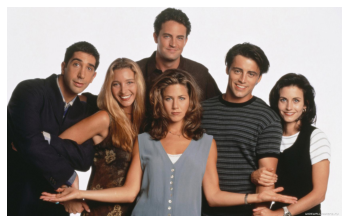

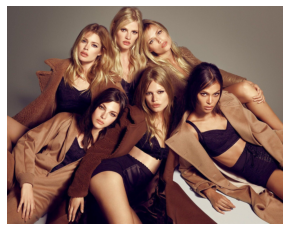

In [7]:
%matplotlib inline
test_image1 = 'https://pics.filmaffinity.com/Friends_TV_Series-105579046-large.jpg' 
test_image1 = Image.open(requests.get(test_image1, stream=True).raw)
plt.figure()
plt.imshow(test_image1)
plt.axis('off')
plt.show()

test_image2 = 'https://alimentola.info/uploads/posts/2021-03/1615555746_8-p-gruppovaya-fotosessiya-9.jpg' 
test_image2 = Image.open(requests.get(test_image2, stream=True).raw)
plt.figure()
plt.imshow(test_image2)
plt.axis('off')
plt.show()

Inference time!

CPU times: user 3.79 s, sys: 378 ms, total: 4.16 s
Wall time: 2.28 s


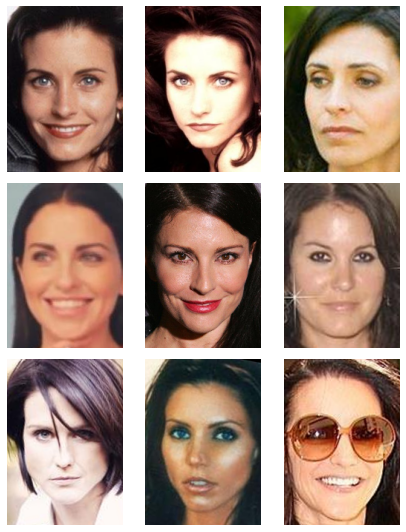

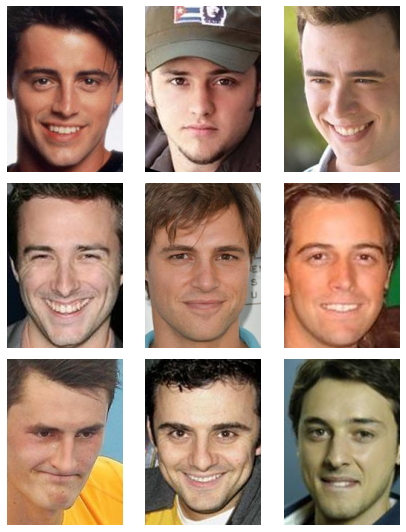

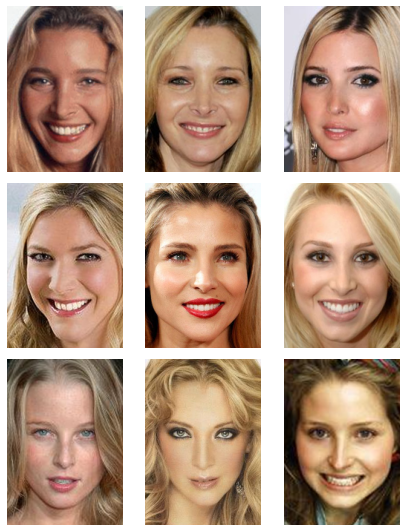

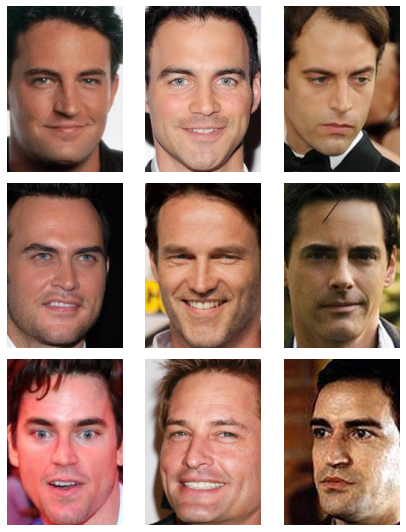

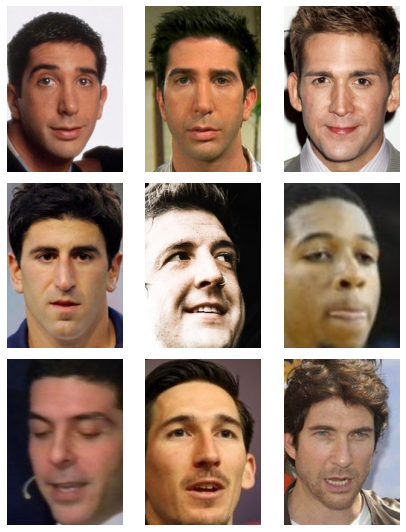

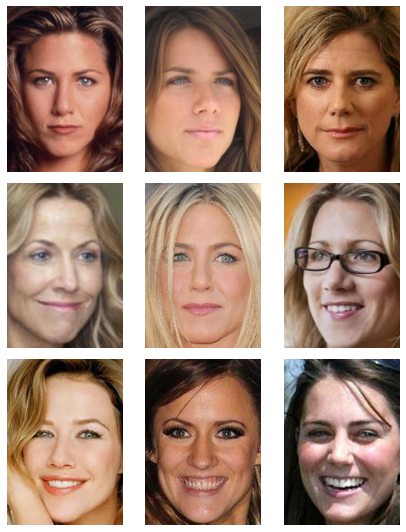

In [8]:
%%time
faces = face_finder.find_faces(img=test_image1)

CPU times: user 3.26 s, sys: 264 ms, total: 3.53 s
Wall time: 1.91 s


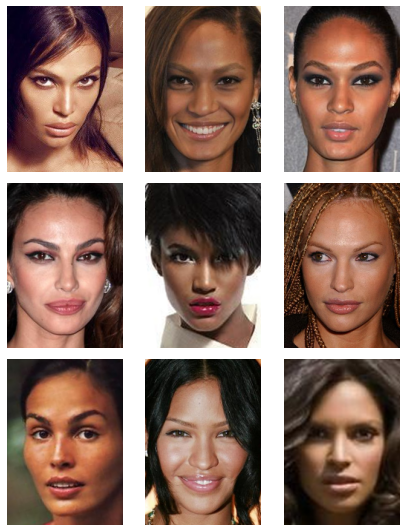

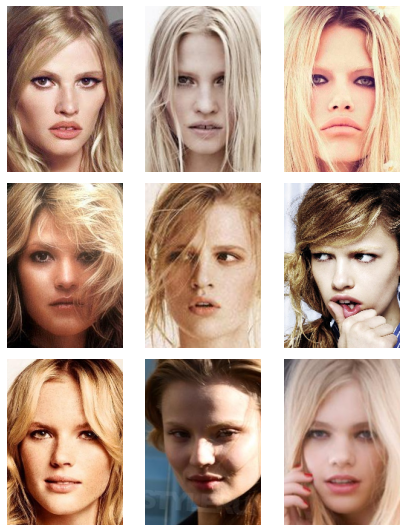

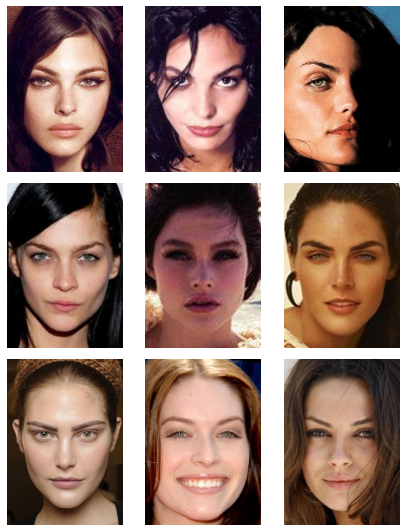

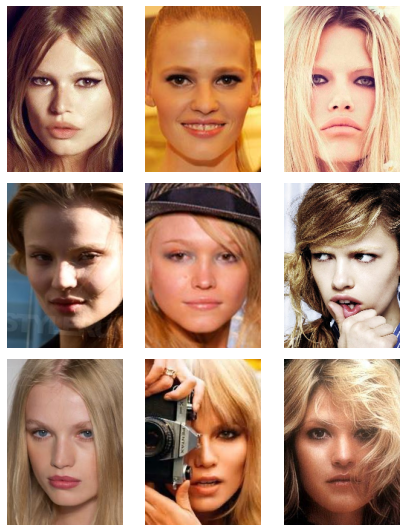

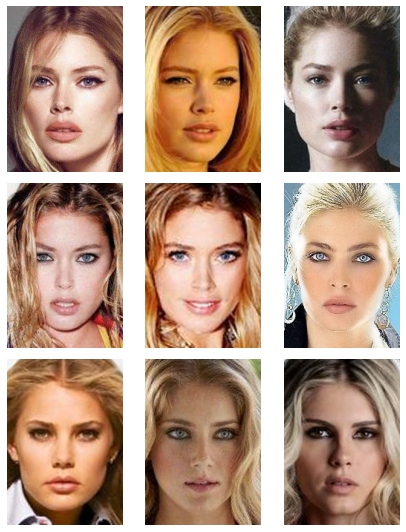

In [9]:
%%time
faces = face_finder.find_faces(img=test_image2)

Not perfect, but it works.

# Webcam inference

QObject::moveToThread: Current thread (0x565089e6ed40) is not the object's thread (0x56508e74cab0).
Cannot move to target thread (0x565089e6ed40)



found face


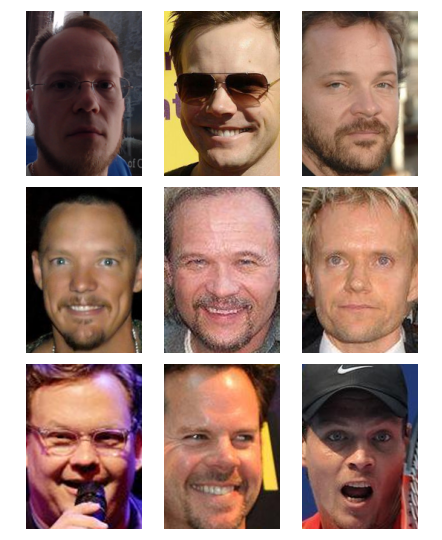

found face


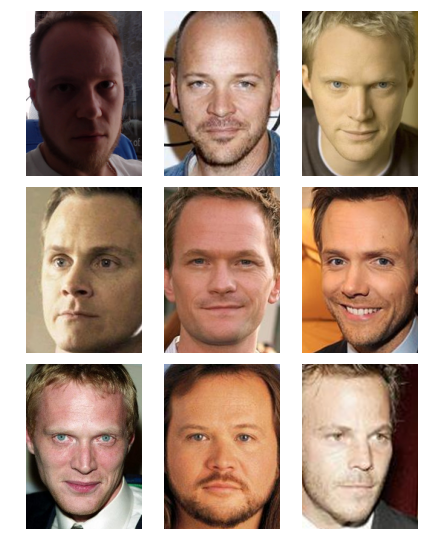

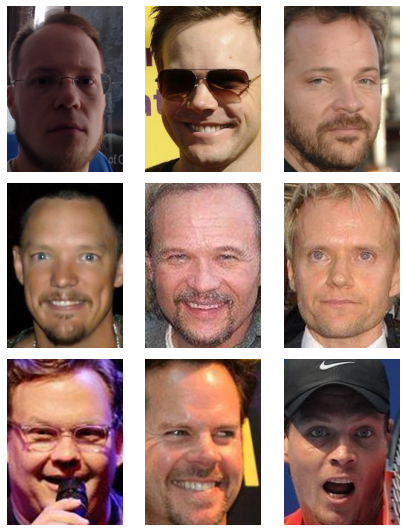

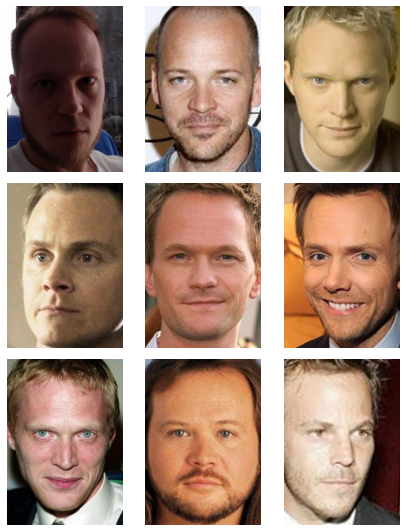

In [10]:
# try to free the camera if it is occupied
try:
    video_capture.release()
except: pass

# use camera 0
video_capture = cv2.VideoCapture(0)

while True:
    # capture frame-by-frame
    return_status, frame = video_capture.read()
    # convert to RGB - reverse color channels
    RGB_img = frame[:,:,::-1].copy()
    
    results = face_finder.detector(frame)
    results = results.xyxy[0].cpu().numpy()[:,:-2]
    
    for row in results:
        row = row.astype(int)
        cv2.rectangle(frame, (row[0], row[1]), 
                      (row[2], row[3]), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == ord('й'):
        break
    elif key == ord('c') or key == ord('с'):
        results = face_finder.find_faces(img=RGB_img)
        
        for r in results:
            print(r['message'])
            if r['message'] == 'found face':
                display(r['image'])
        
# when everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

Ok, so the model have some problems. The main one - it learns haircut, glasses, face rotation and other "meta"-features as a part of the face embedding.